In [1]:
import os


In [2]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:


import requests
import pandas as pd
import numpy as np

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools import Columns
from rectools.dataset import Dataset

import matplotlib.pyplot as plt
import typing as tp
from tqdm import tqdm


# Acquire dataset

In [5]:
# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)


kion dataset download: 100%|█████████▉| 78.6M/78.8M [00:09<00:00, 5.66MiB/s]

In [6]:
!unzip -y kion_train.zip

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore any Unicode fields
  -C  mat

In [7]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')


# Data info

---
### interactions

In [8]:
pd.concat([interactions.head(), interactions.tail()])


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [9]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 208.9+ MB


---
### items

In [10]:
pd.concat([items.head(), items.tail()])


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н..."
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"
15962,3206,series,Гоша,NaN,2019.0,комедии,Россия,0.0,16.0,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия"


In [11]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


---
### users

In [12]:
pd.concat([users.head(), users.tail()])


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [13]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


# Fake users

In [14]:
max_id = users["user_id"].max()
print(max_id)

1097558


In [15]:
fake_user_ids = []

###  Любитель триллеров
Так как одна из фич для айтемов - это жанр, проставим пользователю фильмы с жанром `триллер`

In [16]:
new_user_id = max_id + 1
fake_user_ids.append(new_user_id)
max_id += 1

In [17]:

thriller_ids = items[(items["genres"]).str.contains("триллер")]["item_id"]
thriller_ids

2        10716
8         9853
17        6881
21        3445
38        1622
         ...  
15923    10288
15939    15699
15945    12880
15958     6443
15960    10632
Name: item_id, Length: 2418, dtype: int64

In [18]:
thriller_ids_sample = thriller_ids.sample(n=20)

In [19]:
last_watch_dt = ["2021-04-13"] * 19
last_watch_dt.append("2021-08-22")
total_dur = np.round(np.random.rand(20) * 10000 + 100).astype(dtype=np.int)
watched_pct = np.round(np.random.rand(20) * 100).astype(dtype=np.int)
data = {
    "user_id": [new_user_id] * 20,
    "item_id": list(thriller_ids_sample),
    "last_watch_dt": last_watch_dt,
    "total_dur": list(total_dur),
    "watched_pct": list(watched_pct)
}
new_interactions = pd.DataFrame(data)
interactions = interactions.append(new_interactions)
new_interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,1097559,6529,2021-04-13,7678,39
1,1097559,8986,2021-04-13,6806,27
2,1097559,13789,2021-04-13,2082,56
3,1097559,9362,2021-04-13,1289,55
4,1097559,11612,2021-04-13,1260,25
5,1097559,10959,2021-04-13,9756,73
6,1097559,3949,2021-04-13,4882,77
7,1097559,7970,2021-04-13,4722,57
8,1097559,8892,2021-04-13,9904,16
9,1097559,7595,2021-04-13,7562,8


In [20]:
pd.concat([interactions.head(), interactions.tail()])


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
15,1097559,10026,2021-04-13,2056,0.0
16,1097559,5928,2021-04-13,6828,99.0
17,1097559,8460,2021-04-13,881,5.0
18,1097559,8226,2021-04-13,1948,64.0
19,1097559,13000,2021-08-22,1223,17.0


In [21]:
data = {
    "user_id": [new_user_id],
    "age": ["age_25_34"],
    "income": ["income_60_90"],
    "sex": "М",
    "kids_flg": [1]
}

new_user = pd.DataFrame(data)
users = users.append(new_user)
new_user

,user_id,age,income,sex,kids_flg
0,1097559,age_25_34,income_60_90,М,1


In [22]:
users[users["user_id"] == new_user_id]

,user_id,age,income,sex,kids_flg
0,1097559,age_25_34,income_60_90,М,1


###  Поклонник спорта
По аналогии с предыдущим, найдем фильмы с жанром `спорт`

In [23]:
new_user_id = max_id + 1
fake_user_ids.append(new_user_id)
max_id += 1

In [24]:
sport_ids = items[(items["genres"]).str.contains("спорт")]["item_id"]
sport_ids

4        16268
35       15702
221      15935
272        849
340       4639
         ...  
15856    14273
15868     6467
15920     9035
15938     3134
15961     4538
Name: item_id, Length: 308, dtype: int64

In [25]:
sport_ids_sample = sport_ids.sample(n=100)

In [26]:
last_watch_dt = ["2021-04-13"] * 99
last_watch_dt.append("2021-08-22")
total_dur = np.round(np.random.rand(100) * 10000 + 100).astype(dtype=np.int)
watched_pct = np.round(np.random.rand(100) * 100).astype(dtype=np.int)
data = {
    "user_id": [new_user_id] * 100,
    "item_id": list(sport_ids_sample),
    "last_watch_dt": last_watch_dt,
    "total_dur": list(total_dur),
    "watched_pct": list(watched_pct)
}

new_interactions = pd.DataFrame(data)
interactions = interactions.append(new_interactions)
new_interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,1097560,5962,2021-04-13,9577,28
1,1097560,7676,2021-04-13,5104,84
2,1097560,4372,2021-04-13,2048,83
3,1097560,14910,2021-04-13,7117,8
4,1097560,1539,2021-04-13,6603,32
...,...,...,...,...,...
95,1097560,8257,2021-04-13,5813,67
96,1097560,9961,2021-04-13,2540,19
97,1097560,1144,2021-04-13,9330,89
98,1097560,10850,2021-04-13,7547,48


In [27]:
data = {
    "user_id": [new_user_id],
    "age": ["age_18_24"],
    "income": ["income_20_40"],
    "sex": ["М"],
    "kids_flg": [0]
}

new_user = pd.DataFrame(data)
users = users.append(new_user)
new_user

,user_id,age,income,sex,kids_flg
0,1097560,age_18_24,income_20_40,М,0


In [28]:
users[users["user_id"] == new_user_id]

,user_id,age,income,sex,kids_flg
0,1097560,age_18_24,income_20_40,М,0


###  Обожает сериалы
Теперь абстрагируемся от жанра и укажим, что пользователь смотрит только сериалы

In [29]:
new_user_id = max_id + 1
fake_user_ids.append(new_user_id)
max_id += 1

In [30]:
series_ids = items[(items["content_type"]).str.contains("series")]["item_id"]
series_ids

76        3965
77        4045
78        2662
79        5297
80        4084
         ...  
15958     6443
15959     2367
15960    10632
15961     4538
15962     3206
Name: item_id, Length: 3961, dtype: int64

In [31]:
series_ids_sample = series_ids.sample(n=100)

In [32]:
last_watch_dt = ["2021-04-13"] * 99
last_watch_dt.append("2021-08-22")
total_dur = np.round(np.random.rand(100) * 10000 + 100).astype(dtype=np.int)
watched_pct = np.round(np.random.rand(100) * 100).astype(dtype=np.int)
data = {
    "user_id": [new_user_id] * 100,
    "item_id": list(series_ids_sample),
    "last_watch_dt": last_watch_dt,
    "total_dur": list(total_dur),
    "watched_pct": list(watched_pct)
}

new_interactions = pd.DataFrame(data)
interactions = interactions.append(new_interactions)
new_interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,1097561,11111,2021-04-13,7188,1
1,1097561,3065,2021-04-13,190,25
2,1097561,6679,2021-04-13,2727,70
3,1097561,1434,2021-04-13,3791,66
4,1097561,5101,2021-04-13,8865,88
...,...,...,...,...,...
95,1097561,15596,2021-04-13,9946,21
96,1097561,14692,2021-04-13,4461,49
97,1097561,1550,2021-04-13,6482,39
98,1097561,3759,2021-04-13,3840,69


In [33]:
data = {
    "user_id": [new_user_id],
    "age": ["age_45_54"],
    "income": ["income_40_60"],
    "sex": ["Ж"],
    "kids_flg": [1]
}

new_user = pd.DataFrame(data)
users = users.append(new_user)
new_user

,user_id,age,income,sex,kids_flg
0,1097561,age_45_54,income_40_60,Ж,1


In [34]:
users[users["user_id"] == new_user_id]

,user_id,age,income,sex,kids_flg
0,1097561,age_45_54,income_40_60,Ж,1


# Small EDA

---
### Users

In [35]:
print(f"Всего уникальных пользователей: {users[Columns.User].nunique():,}")

Всего уникальных пользователей: 840,200


In [36]:
def plot_normalized_barh_chart(
        dataframe: pd.DataFrame,
        column_name: str,
        title: str,
        figsize: tp.Tuple[int, int] = (12, 7),
        annotate_chart: bool = True,
        xlabel: tp.Optional[str] = None,
        ylabel: tp.Optional[str] = None,
) -> plt.Axes.axes:
    ax = (
        dataframe[column_name]
        .value_counts(dropna=False, normalize=True)
        .sort_index()
        .plot(
            kind='barh',
            grid=True,
            title=title,
            figsize=figsize,
            xlabel=xlabel,
            ylabel=ylabel,
        )
    )

    if annotate_chart:
        for bars in ax.containers:
            ax.bar_label(bars, labels=[f'{x:.1%}' for x in bars.datavalues])

In [37]:
users['sex'] = users['sex'].map({'Ж': 1, 'М': 0})

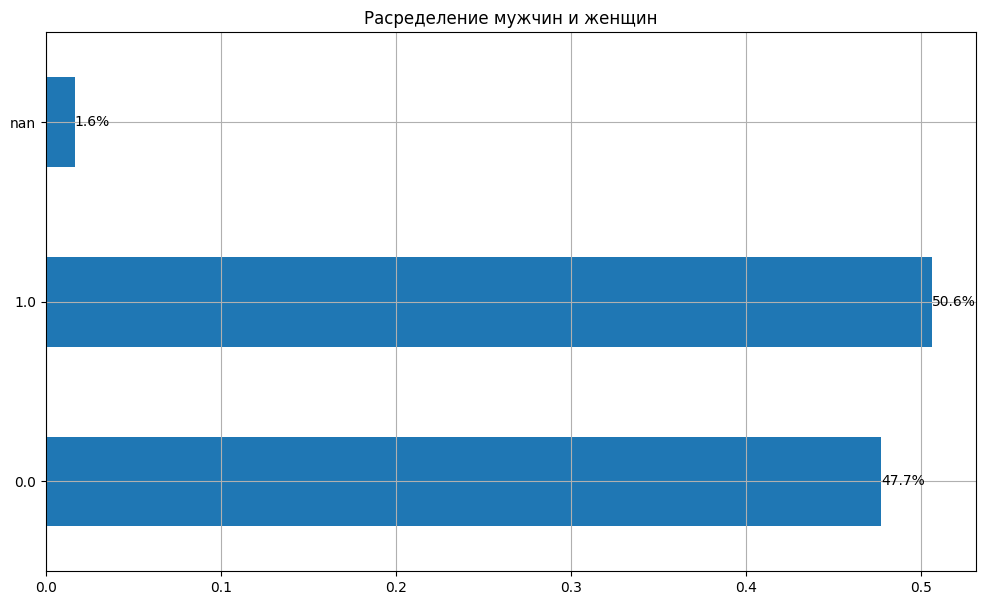

In [38]:
plot_normalized_barh_chart(users, 'sex', 'Расределение мужчин и женщин')

In [39]:
age_category = pd.CategoricalDtype(
    categories=[
        'age_18_24',
        'age_25_34',
        'age_35_44',
        'age_45_54',
        'age_55_64',
        'age_65_inf',
    ],
    ordered=True,
)

In [40]:
users['age'] = users['age'].astype(age_category)

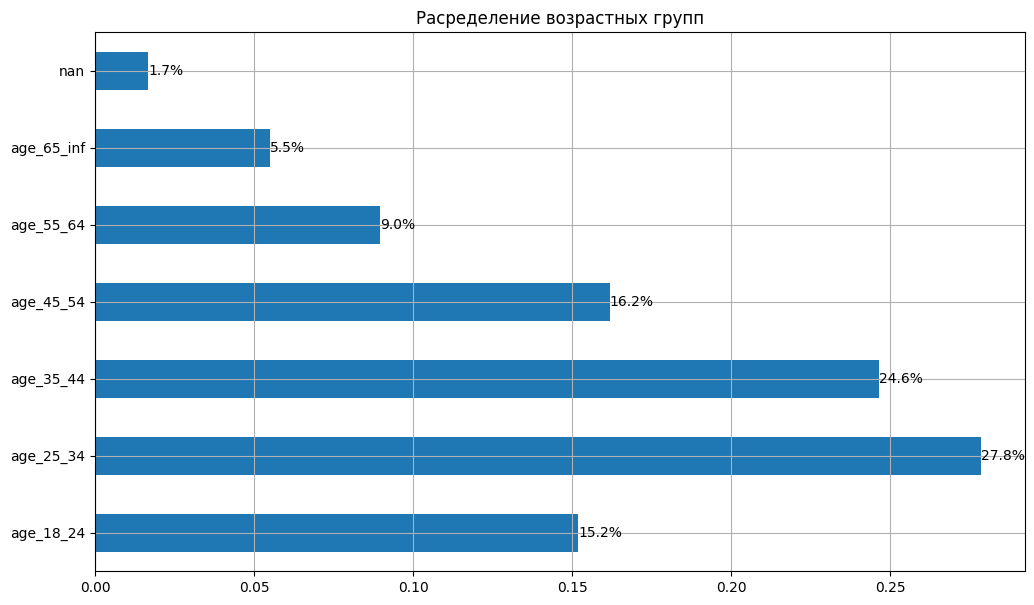

In [41]:
plot_normalized_barh_chart(users, 'age', 'Расределение возрастных групп')

In [42]:
income_category = pd.CategoricalDtype(
    categories=[
        'income_0_20',
        'income_20_40',
        'income_40_60',
        'income_60_90',
        'income_90_150',
        'income_150_inf',
    ],
    ordered=True,
)

In [43]:
users['income'] = users['income'].astype(income_category)

In [44]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,0.0,1
1,962099,age_18_24,income_20_40,0.0,0
2,1047345,age_45_54,income_40_60,1.0,0
3,721985,age_45_54,income_20_40,1.0,0
4,704055,age_35_44,income_60_90,1.0,0
...,...,...,...,...,...
840195,590706,NaN,NaN,1.0,0
840196,166555,age_65_inf,income_20_40,1.0,0
0,1097559,age_25_34,income_60_90,0.0,1
0,1097560,age_18_24,income_20_40,0.0,0


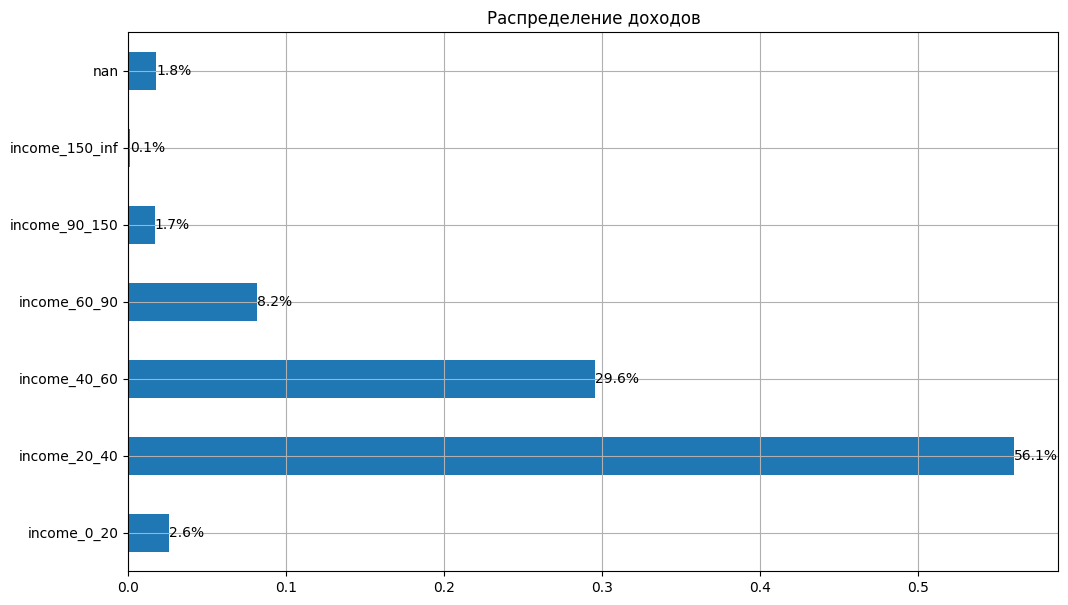

In [45]:
plot_normalized_barh_chart(users, 'income', 'Распределение доходов')

### Items

In [46]:
print(f"Всего уникальных айтемов: {items[Columns.Item].nunique():,}")

Всего уникальных айтемов: 15,963


In [47]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [48]:
YEAR_FROM = 1990
STEP_SIZE = 5
bins = [year for year in range(YEAR_FROM, int(items['release_year'].max()) + STEP_SIZE, STEP_SIZE)]

In [49]:
bins = [int(items['release_year'].min())] + bins

In [50]:
items['year_bin'] = pd.cut(items['release_year'],
                           bins=bins, include_lowest=True)

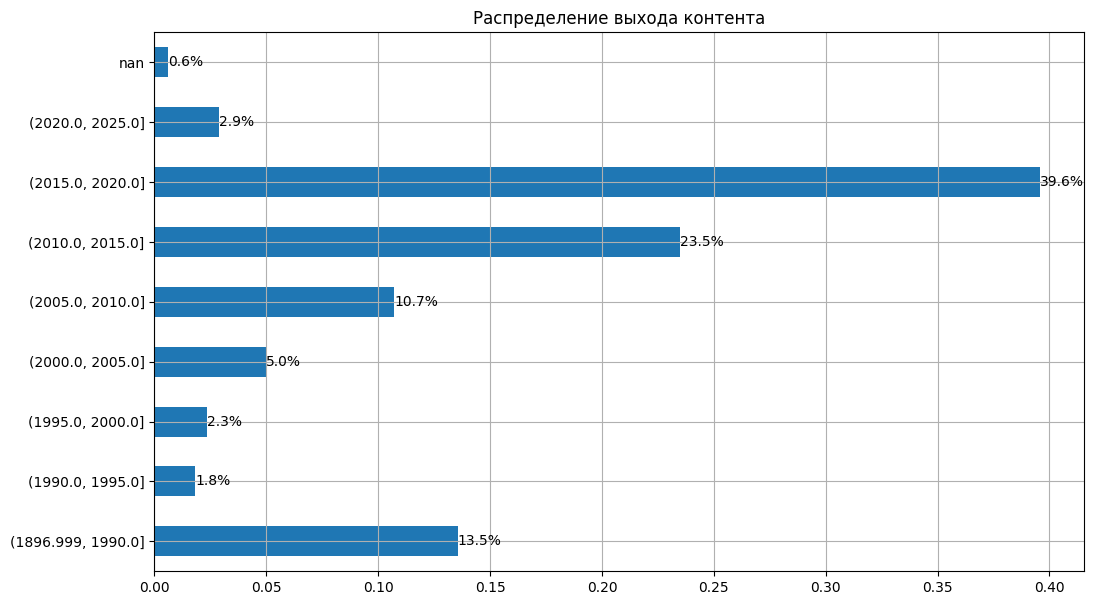

In [51]:
plot_normalized_barh_chart(items, 'year_bin', 'Распределение выхода контента')

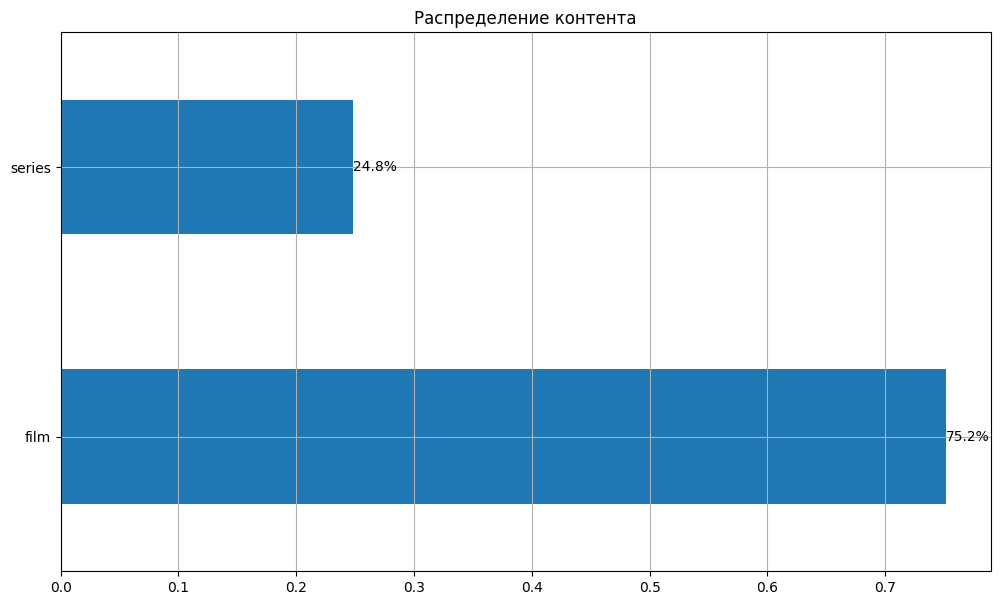

In [52]:
plot_normalized_barh_chart(items, 'content_type', 'Распределение контента')

### Interactions

In [53]:
print('Кол-во уникальных пользователей и айтемов в интеракциях')
interactions[Columns.UserItem].nunique()

Кол-во уникальных пользователей и айтемов в интеракциях


user_id    962182
item_id     15714
dtype: int64

In [54]:
Columns.Datetime = 'last_watch_dt'

In [55]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [56]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
95,1097561,15596,2021-04-13,9946,21.0
96,1097561,14692,2021-04-13,4461,49.0
97,1097561,1550,2021-04-13,6482,39.0
98,1097561,3759,2021-04-13,3840,69.0


In [57]:
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

In [58]:
interactions[Columns.Datetime].str.len().value_counts()

10    5476471
Name: last_watch_dt, dtype: int64

In [59]:
interactions[Columns.Datetime].min(), interactions[Columns.Datetime].max()

('2021-03-13', '2021-08-22')

# Train/Test split

In [60]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [61]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
95,1097561,15596,2021-04-13,9946,21.0
96,1097561,14692,2021-04-13,4461,49.0
97,1097561,1550,2021-04-13,6482,39.0
98,1097561,3759,2021-04-13,3840,69.0


In [62]:
interactions.dtypes

user_id                   int64
item_id                   int64
last_watch_dt    datetime64[ns]
total_dur                 int64
watched_pct             float64
dtype: object

In [63]:
max_date = interactions[Columns.Datetime].max()

Видим, что есть какие-то выбросы, пока на них не обращаем внимание, посмотрим, что получается

In [64]:
interactions['total_dur'].describe(percentiles=[.01, .1, .5, .9, .99]).round(2)

count     5476471.00
mean         8295.36
std         48567.03
min             1.00
1%              3.00
10%            42.00
50%          2898.00
90%         15111.00
99%         90079.30
max      80411672.00
Name: total_dur, dtype: float64

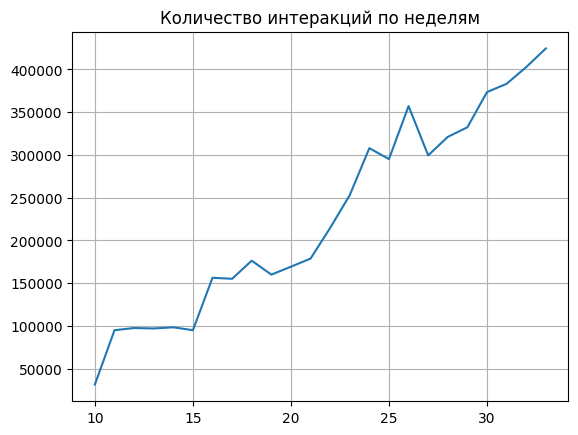

In [65]:
(
    interactions[Columns.Datetime].dt.isocalendar().week
    .value_counts(sort=False)
    .sort_index()
    .plot(grid=True, title='Количество интеракций по неделям')
);

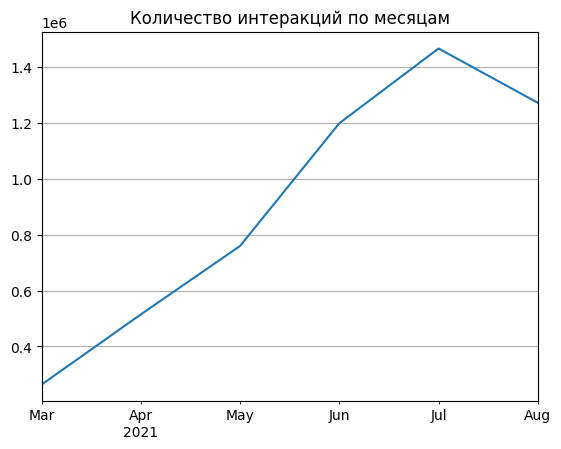

In [66]:
(
    interactions[Columns.Datetime].dt.to_period('M')
    .value_counts(sort=False)
    .sort_index()
    .plot(grid=True, title='Количество интеракций по месяцам')
);

In [67]:
(interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)).sum()

490985

In [68]:
interactions['watched_pct'].describe().round()

count    5475643.0
mean          46.0
std           42.0
min            0.0
25%            4.0
50%           32.0
75%          100.0
max          100.0
Name: watched_pct, dtype: float64

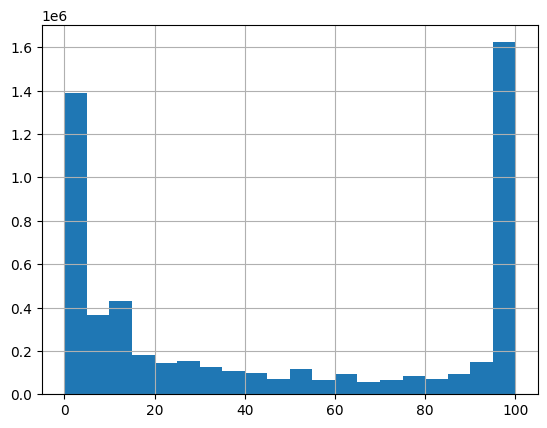

In [69]:
interactions['watched_pct'].hist(bins=20);

In [70]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)

In [71]:
interactions[Columns.Weight].value_counts(normalize=True)

3    0.660181
1    0.339819
Name: weight, dtype: float64

In [72]:
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

kion dataset download: 100%|██████████| 78.8M/78.8M [00:19<00:00, 5.66MiB/s]

train: (4985486, 6)
test: (490985, 6)


In [73]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [74]:
# отфильтруем холодных пользователей из теста
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [75]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

# Features

### Users

In [76]:
users.isnull().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

In [77]:
users.nunique()

user_id     840200
age              6
income           6
sex              2
kids_flg         2
dtype: int64

In [78]:
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()

In [79]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,0.0,1
1,962099,age_18_24,income_20_40,0.0,0
3,721985,age_45_54,income_20_40,1.0,0
4,704055,age_35_44,income_60_90,1.0,0
5,1037719,age_45_54,income_60_90,0.0,0
...,...,...,...,...,...
840189,191349,age_45_54,income_40_60,0.0,1
840190,393868,age_25_34,income_20_40,0.0,0
0,1097559,age_25_34,income_60_90,0.0,1
0,1097560,age_18_24,income_20_40,0.0,0


In [80]:
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
pd.concat([user_features.head(), user_features.tail()])

,id,value,feature
0,973171,0.0,sex
1,962099,0.0,sex
3,721985,1.0,sex
4,704055,1.0,sex
5,1037719,0.0,sex
840189,191349,income_40_60,income
840190,393868,income_20_40,income
0,1097559,income_60_90,income
0,1097560,income_20_40,income
0,1097561,income_40_60,income


### Items

In [81]:
items.isnull().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
year_bin           98
dtype: int64

In [82]:
items.nunique()

item_id         15963
content_type        2
title           15293
title_orig      10575
release_year      105
genres           2771
countries         687
for_kids            2
age_rating          6
studios            38
directors        7973
actors          12996
description     15619
keywords        15492
year_bin            8
dtype: int64

In [83]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()

In [84]:
items

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...","(2000.0, 2005.0]"
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...","(2010.0, 2015.0]"
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...","(2010.0, 2015.0]"
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...","(2010.0, 2015.0]"
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...","(1896.999, 1990.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н...","(2015.0, 2020.0]"
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия","(2015.0, 2020.0]"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия","(2015.0, 2020.0]"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия","(2015.0, 2020.0]"


#### Genre

In [85]:
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


#### Content

In [86]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
content_feature.head()

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type


In [87]:
item_features = pd.concat((genre_feature, content_feature))

In [88]:
pd.concat([item_features.head(), item_features.tail()])

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre
15958,6443,series,content_type
15959,2367,series,content_type
15960,10632,series,content_type
15961,4538,series,content_type
15962,3206,series,content_type


# Metrics

In [89]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in range(1, 11):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [90]:
metrics

{'Precision@1': Precision(k=1),
 'Precision@2': Precision(k=2),
 'Precision@3': Precision(k=3),
 'Precision@4': Precision(k=4),
 'Precision@5': Precision(k=5),
 'Precision@6': Precision(k=6),
 'Precision@7': Precision(k=7),
 'Precision@8': Precision(k=8),
 'Precision@9': Precision(k=9),
 'Precision@10': Precision(k=10),
 'Recall@1': Recall(k=1),
 'Recall@2': Recall(k=2),
 'Recall@3': Recall(k=3),
 'Recall@4': Recall(k=4),
 'Recall@5': Recall(k=5),
 'Recall@6': Recall(k=6),
 'Recall@7': Recall(k=7),
 'Recall@8': Recall(k=8),
 'Recall@9': Recall(k=9),
 'Recall@10': Recall(k=10),
 'MAP@1': MAP(k=1, divide_by_k=False),
 'MAP@2': MAP(k=2, divide_by_k=False),
 'MAP@3': MAP(k=3, divide_by_k=False),
 'MAP@4': MAP(k=4, divide_by_k=False),
 'MAP@5': MAP(k=5, divide_by_k=False),
 'MAP@6': MAP(k=6, divide_by_k=False),
 'MAP@7': MAP(k=7, divide_by_k=False),
 'MAP@8': MAP(k=8, divide_by_k=False),
 'MAP@9': MAP(k=9, divide_by_k=False),
 'MAP@10': MAP(k=10, divide_by_k=False)}

# Models

In [91]:
%time
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)
K_RECOS = 10
SEED = 123
NUM_THREADS = 16
N_FACTORS = (32, 64)
N_EPOCHS = 1
USER_ALPHA = 0
ITEM_ALPHA = 0
LEARNING_RATE = (0.05, 0.01)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [92]:
models = {}

In [93]:
def augment_inner_product(factors):
    normed_factors = np.linalg.norm(factors, axis=1)
    max_norm = normed_factors.max()

    extra_dim = np.sqrt(max_norm ** 2 - normed_factors ** 2).reshape(-1, 1)
    augmented_factors = np.append(factors, extra_dim, axis=1)
    return max_norm, augmented_factors

In [94]:
%time
from service.rec_models.als_model import ALSModel

for is_fitting_features in (True, False):
    for n_factors in N_FACTORS:
        models[f"ALS_{n_factors}_{is_fitting_features}"] = (
            ALSModel(
                dataset=dataset,
                n_factors=n_factors,
                is_fitting_features=is_fitting_features,
                n_threads=NUM_THREADS,
                seed=SEED
            )
        )

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.58 µs


In [95]:
%time
from service.rec_models.factoring_machine_model import FactoringMachineModel

for n_factors in N_FACTORS:
    for lr in LEARNING_RATE:
        models[f"LightFM_{n_factors}_{lr}"] = (
            FactoringMachineModel(
                dataset=dataset,
                n_factors=n_factors,
                loss="warp",
                lr=lr,
                ua=USER_ALPHA,
                ia=ITEM_ALPHA,
                n_epoch=N_EPOCHS,
                n_threads=NUM_THREADS,
                seed=SEED
            )
        )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


In [96]:
models

{'ALS_32_True': <service.rec_models.als_model.ALSModel at 0x7f87fa444430>,
 'ALS_64_True': <service.rec_models.als_model.ALSModel at 0x7f87fa444b20>,
 'ALS_32_False': <service.rec_models.als_model.ALSModel at 0x7f87f8d816a0>,
 'ALS_64_False': <service.rec_models.als_model.ALSModel at 0x7f87f8d817f0>,
 'LightFM_32_0.05': <service.rec_models.factoring_machine_model.FactoringMachineModel at 0x7f87fbaf8040>,
 'LightFM_32_0.01': <service.rec_models.factoring_machine_model.FactoringMachineModel at 0x7f87fa680f40>,
 'LightFM_64_0.05': <service.rec_models.factoring_machine_model.FactoringMachineModel at 0x7f87fab3bf70>,
 'LightFM_64_0.01': <service.rec_models.factoring_machine_model.FactoringMachineModel at 0x7f87fbaf8310>}

In [97]:
TEST_USERS = test[Columns.User].unique()

In [98]:
TEST_USERS

array([ 203219,  200197,   73446, ..., 1097559, 1097560, 1097561])

In [99]:
%time
results = []
for model_name, model in models.items():
    model_quality = {'model': model_name}

    recos = model.model.recommend(
        users=TEST_USERS,
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)
    model_quality.update(metric_values)
    results.append(model_quality)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


In [100]:
df_quality = pd.DataFrame(results).T

df_quality.columns = df_quality.iloc[0]

df_quality.drop('model', inplace=True)

In [101]:
df_quality.style.highlight_max(color='lightgreen', axis=1)

model,ALS_32_True,ALS_64_True,ALS_32_False,ALS_64_False,LightFM_32_0.05,LightFM_32_0.01,LightFM_64_0.05,LightFM_64_0.01
Precision@1,0.080696,0.081935,0.062303,0.062870,0.082457,0.081722,0.081528,0.082581
Recall@1,0.041391,0.042242,0.030905,0.031339,0.042086,0.042329,0.041511,0.042453
Precision@2,0.068685,0.068884,0.055324,0.055806,0.069729,0.069857,0.070482,0.070101
Recall@2,0.068987,0.069297,0.054275,0.054738,0.069486,0.070177,0.070092,0.070257
Precision@3,0.058786,0.058830,0.050838,0.051490,0.061861,0.062684,0.062749,0.063029
Recall@3,0.086812,0.086957,0.073727,0.074370,0.091121,0.093115,0.092203,0.093405
Precision@4,0.052195,0.052330,0.047024,0.047595,0.055866,0.056683,0.056298,0.056846
Recall@4,0.101268,0.101609,0.090043,0.090901,0.108471,0.111190,0.109190,0.111159
Precision@5,0.046856,0.046789,0.043510,0.043703,0.050549,0.051271,0.050807,0.051529
Recall@5,0.112475,0.112332,0.102698,0.102610,0.121482,0.124693,0.121798,0.124966


In [102]:
def _recommend_all(query_factors, index_factors, topn=10):
    output = query_factors.dot(index_factors.T)
    argpartition_indices = np.argpartition(output, -topn)[:, -topn:]

    x_indices = np.repeat(np.arange(output.shape[0]), topn)
    y_indices = argpartition_indices.flatten()
    top_value = output[x_indices, y_indices].reshape(output.shape[0], topn)
    top_indices = np.argsort(top_value)[:, ::-1]

    y_indices = top_indices.flatten()
    top_indices = argpartition_indices[x_indices, y_indices]
    labels = top_indices.reshape(-1, topn)
    distances = output[x_indices, top_indices].reshape(-1, topn)
    return labels, distances

In [103]:
import hnswlib

model = models["LightFM_64_0.01"].model
user_embeddings, item_embeddings = model.get_vectors(
    dataset
)

labels, _ = _recommend_all(
    user_embeddings[[-3, -2, -1], :],
    item_embeddings
)

print(labels)

label_fake_1 = labels[0, :].flatten()
label_fake_2 = labels[1, :].flatten()
label_fake_3 = labels[2, :].flatten()

[[ 18  29  41  30 119  60  98 171 266  84]
 [ 18 119  29  41  98 171  30  60  27 103]
 [ 29  18 119 103 171  59  98  27  11 776]]


In [104]:
acquired_items = items[items["item_id"].isin(label_fake_1)]
acquired_items


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin,genre
36,41,film,Один шанс из тысячи,One Chance in a Thousand,1968.0,"русские, военные, приключения",СССР,NaN,12.0,NaN,Леон Кочарян,"Николай Гринько, Александр Фадеев, Владимир Ма...",1942 год. Группа советских диверсантов с трудо...,"Один, шанс, из, тысячи, 1968, СССР","(1896.999, 1990.0]","[русские, военные, приключения]"
2413,84,film,Рожденный после смерти,Strange But True,2019.0,"драмы, зарубежные, триллеры",Канада,NaN,18.0,NaN,Роуэн Этейл,"Аллегра Фултон, Блайт Даннер, Брайан Кокс, Ван...","Через пять лет после трагической гибели Ронни,...","Рожденный, после, смерти, 2019, Канада, месть,...","(2015.0, 2020.0]","[драмы, зарубежные, триллеры]"
3309,60,film,А вот и она (с тифлокомментарием),And So It Goes (with Audio Description),2014.0,"мелодрамы, зарубежные, комедии",США,NaN,12.0,NaN,Роб Райнер,"Майкл Дуглас, Дайан Китон, Йайа ДаКоста, Стерл...",После смерти жены пожилой Орен Литтл превращае...,"вот, она, тифлокомментарием, 2014, США","(2010.0, 2015.0]","[мелодрамы, зарубежные, комедии]"
5699,171,film,Уотергейт. Крушение Белого дома (жестовым языком),Mark Felt: The Man Who Brought Down the White ...,2017.0,"драмы, исторические, зарубежные, триллеры",США,NaN,16.0,NaN,Питер Ландесман,"Лиам Нисон, Мартон Чокаш, Дайан Лэйн, Тони Гол...",Зам. начальника ФБР Марк Фелт готов пожертвова...,"Уотергейт, Крушение, Белого, дома, жестовым, я...","(2015.0, 2020.0]","[драмы, исторические, зарубежные, триллеры]"
8501,30,film,Thomas & Friends: Легенда Содора о пропавших с...,Thomas & Friends: Sodor's Legend of the Lost T...,2015.0,"приключения, зарубежные, семейное, фэнтези, ко...",Великобритания,NaN,0.0,NaN,Дэвид Стоутен,"Джон Хёрт, Эдди Редмэйн, Джейми Кэмпбелл Бауэр...",На острове Содор живут необычные и говорящие п...,"Thomas, Friends, Легенда, Содора, о, пропавших...","(2010.0, 2015.0]","[приключения, зарубежные, семейное, фэнтези, к..."
10810,29,film,Похитители велосипедов,Ladri di biciclette,1948.0,драмы,Италия,NaN,12.0,NaN,Витторио Де Сика,"Ламберто Маджорани, Энцо Стайола, Лианелла Кар...","Послевоенный Рим, давно неработающий Антонио в...","рим, италия, итальянский, езда на велосипеде, ...","(1896.999, 1990.0]",[драмы]
12628,18,film,Бесконечная ночь,Hard Night Falling,2019.0,"боевики, триллеры, криминал, детективы","Италия, США",NaN,16.0,NaN,Джорджо Бруно,"Дольф Лундгрен, Хал Яманоути, Наталия Берн, Ма...",Криминальный авторитет Горо планирует ограбить...,"заложник, ограбление, головорез, прихвостни, 2...","(2015.0, 2020.0]","[боевики, триллеры, криминал, детективы]"
14983,98,series,Ходячие мертвецы,The Walking Dead,2010.0,"драмы, ужасы",США,NaN,18.0,NaN,Грег Никотеро,"Эндрю Линкольн, Норман Ридус, Джон Бернтал, Са...",Данный сериал распространяется по особой модел...,"2010-е, американец корейского происхождения, а...","(2005.0, 2010.0]","[драмы, ужасы]"


In [105]:
acquired_items = items[items["item_id"].isin(label_fake_2)]
acquired_items


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin,genre
36,41,film,Один шанс из тысячи,One Chance in a Thousand,1968.0,"русские, военные, приключения",СССР,NaN,12.0,NaN,Леон Кочарян,"Николай Гринько, Александр Фадеев, Владимир Ма...",1942 год. Группа советских диверсантов с трудо...,"Один, шанс, из, тысячи, 1968, СССР","(1896.999, 1990.0]","[русские, военные, приключения]"
970,27,film,Кружева,NaN,2014.0,"русские, мелодрамы",Россия,NaN,12.0,NaN,Иван Мережко,"Анатолий Голуб, Андрей Карако, Валерия Арланов...",Мелодрама режиссера Ивана Мережко рассказывает...,"Кружева, 2014, Россия, жизнь, любовь, мода, пр...","(2010.0, 2015.0]","[русские, мелодрамы]"
3309,60,film,А вот и она (с тифлокомментарием),And So It Goes (with Audio Description),2014.0,"мелодрамы, зарубежные, комедии",США,NaN,12.0,NaN,Роб Райнер,"Майкл Дуглас, Дайан Китон, Йайа ДаКоста, Стерл...",После смерти жены пожилой Орен Литтл превращае...,"вот, она, тифлокомментарием, 2014, США","(2010.0, 2015.0]","[мелодрамы, зарубежные, комедии]"
5699,171,film,Уотергейт. Крушение Белого дома (жестовым языком),Mark Felt: The Man Who Brought Down the White ...,2017.0,"драмы, исторические, зарубежные, триллеры",США,NaN,16.0,NaN,Питер Ландесман,"Лиам Нисон, Мартон Чокаш, Дайан Лэйн, Тони Гол...",Зам. начальника ФБР Марк Фелт готов пожертвова...,"Уотергейт, Крушение, Белого, дома, жестовым, я...","(2015.0, 2020.0]","[драмы, исторические, зарубежные, триллеры]"
8501,30,film,Thomas & Friends: Легенда Содора о пропавших с...,Thomas & Friends: Sodor's Legend of the Lost T...,2015.0,"приключения, зарубежные, семейное, фэнтези, ко...",Великобритания,NaN,0.0,NaN,Дэвид Стоутен,"Джон Хёрт, Эдди Редмэйн, Джейми Кэмпбелл Бауэр...",На острове Содор живут необычные и говорящие п...,"Thomas, Friends, Легенда, Содора, о, пропавших...","(2010.0, 2015.0]","[приключения, зарубежные, семейное, фэнтези, к..."
10810,29,film,Похитители велосипедов,Ladri di biciclette,1948.0,драмы,Италия,NaN,12.0,NaN,Витторио Де Сика,"Ламберто Маджорани, Энцо Стайола, Лианелла Кар...","Послевоенный Рим, давно неработающий Антонио в...","рим, италия, итальянский, езда на велосипеде, ...","(1896.999, 1990.0]",[драмы]
11625,103,film,Ведьма войны,Rebelle,2012.0,"драмы, зарубежные, военные",Канада,NaN,18.0,NaN,Ким Нгуйен,"Алекс Херабо, Алекси Сабве, Ален Лино Мик Эли ...",Военная драма от канадского режиссера Кима Нгу...,"Ведьма, войны, 2012, Канада, жизнь, преображен...","(2010.0, 2015.0]","[драмы, зарубежные, военные]"
12628,18,film,Бесконечная ночь,Hard Night Falling,2019.0,"боевики, триллеры, криминал, детективы","Италия, США",NaN,16.0,NaN,Джорджо Бруно,"Дольф Лундгрен, Хал Яманоути, Наталия Берн, Ма...",Криминальный авторитет Горо планирует ограбить...,"заложник, ограбление, головорез, прихвостни, 2...","(2015.0, 2020.0]","[боевики, триллеры, криминал, детективы]"
14983,98,series,Ходячие мертвецы,The Walking Dead,2010.0,"драмы, ужасы",США,NaN,18.0,NaN,Грег Никотеро,"Эндрю Линкольн, Норман Ридус, Джон Бернтал, Са...",Данный сериал распространяется по особой модел...,"2010-е, американец корейского происхождения, а...","(2005.0, 2010.0]","[драмы, ужасы]"


In [106]:
acquired_items = items[items["item_id"].isin(label_fake_3)]
acquired_items


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin,genre
970,27,film,Кружева,NaN,2014.0,"русские, мелодрамы",Россия,NaN,12.0,NaN,Иван Мережко,"Анатолий Голуб, Андрей Карако, Валерия Арланов...",Мелодрама режиссера Ивана Мережко рассказывает...,"Кружева, 2014, Россия, жизнь, любовь, мода, пр...","(2010.0, 2015.0]","[русские, мелодрамы]"
5699,171,film,Уотергейт. Крушение Белого дома (жестовым языком),Mark Felt: The Man Who Brought Down the White ...,2017.0,"драмы, исторические, зарубежные, триллеры",США,NaN,16.0,NaN,Питер Ландесман,"Лиам Нисон, Мартон Чокаш, Дайан Лэйн, Тони Гол...",Зам. начальника ФБР Марк Фелт готов пожертвова...,"Уотергейт, Крушение, Белого, дома, жестовым, я...","(2015.0, 2020.0]","[драмы, исторические, зарубежные, триллеры]"
10810,29,film,Похитители велосипедов,Ladri di biciclette,1948.0,драмы,Италия,NaN,12.0,NaN,Витторио Де Сика,"Ламберто Маджорани, Энцо Стайола, Лианелла Кар...","Послевоенный Рим, давно неработающий Антонио в...","рим, италия, итальянский, езда на велосипеде, ...","(1896.999, 1990.0]",[драмы]
11625,103,film,Ведьма войны,Rebelle,2012.0,"драмы, зарубежные, военные",Канада,NaN,18.0,NaN,Ким Нгуйен,"Алекс Херабо, Алекси Сабве, Ален Лино Мик Эли ...",Военная драма от канадского режиссера Кима Нгу...,"Ведьма, войны, 2012, Канада, жизнь, преображен...","(2010.0, 2015.0]","[драмы, зарубежные, военные]"
12628,18,film,Бесконечная ночь,Hard Night Falling,2019.0,"боевики, триллеры, криминал, детективы","Италия, США",NaN,16.0,NaN,Джорджо Бруно,"Дольф Лундгрен, Хал Яманоути, Наталия Берн, Ма...",Криминальный авторитет Горо планирует ограбить...,"заложник, ограбление, головорез, прихвостни, 2...","(2015.0, 2020.0]","[боевики, триллеры, криминал, детективы]"
14636,776,film,Куколка,Baby Doll,1988.0,"драмы, спорт, мелодрамы",СССР,NaN,18.0,NaN,Исаак Фридберг,"Наталья Назарова, Владимир Меньшов, Светлана Ш...",Главная героиня учится в школе. Но перед сверс...,"Куколка, 1988, СССР","(1896.999, 1990.0]","[драмы, спорт, мелодрамы]"
14708,59,film,Три мушкетера,NaN,2005.0,"мюзиклы, русские, комедии",Россия,NaN,12.0,NaN,Тина Баркалая,"Александр Пикалов, Алена Свиридова, Алика Смех...",В новогоднем мюзикле «Три мушкетера» авторы пр...,"Три, мушкетера, 2005, Россия, друзья, интриги,...","(2000.0, 2005.0]","[мюзиклы, русские, комедии]"
14983,98,series,Ходячие мертвецы,The Walking Dead,2010.0,"драмы, ужасы",США,NaN,18.0,NaN,Грег Никотеро,"Эндрю Линкольн, Норман Ридус, Джон Бернтал, Са...",Данный сериал распространяется по особой модел...,"2010-е, американец корейского происхождения, а...","(2005.0, 2010.0]","[драмы, ужасы]"
